## Aggregation and Resampling
*Written by Friedrich Knuth, Rutgers University, May 21, 2018, as revised by Sage Lichtenwalner June 13, 2018*

In this example we will learn how to programmatically download and work with OOI NetCDF data from within a notebook. 

We will use data from the 3D Thermistor Array deployed in the ASHES Vent field at Axial Seamount for this example, but the mechanics apply to all datasets that are processed through the OOI Cyberinfrastructure (CI) system. 

In this example, you will learn:
* how to find the data you are looking for
* how to use the machine to machine API to request data
* how to load the NetCDF data into your notebook, once the data request has completed
* how to explore and plot data

A great resource for data wrangling and exploration in python can be found at https://chrisalbon.com/. Tip: add "albon" to your search in google when trying to find a common technique and chances are Chris Albon has made a post on how to do it.

The difference between a NetCDF and JSON data request is that NetCDF files are served asynchronously and delivered to a THREDDS server, while the JSON data response is synchronous (instantaneous) and served as a JSON object in the GET response. NetCDF data is undecimated (full data set), while the JSON response is decimated down to a maximum of 20,000 data points.

*Note, given the size of the dataset, parts of this notebook are rather processing intensive and it may not run well on Google Colab or your local machine.  High-performance computing solutions (e.g. [pangeo](http://pangeo-data.org)) might be a better option.

## Setup your API Information
Login in at https://ooinet.oceanobservatories.org/ and obtain your <b>API username and API token</b> under your profile (top right corner), or use the credentials provided below.

In [0]:
username = ''
token = ''

## Find and request the data

In [0]:
import requests
import time

The ingredients being used to build the data_request_url can be found here. For this example, we will use the data from the 3D Thermistor Array (TMPSF)
http://ooi.visualocean.net/instruments/view/RS03ASHS-MJ03B-07-TMPSFA301

![RS03ASHS-MJ03B-07-TMPSFA301](https://github.com/ooi-data-review/ooi_datateam_notebooks/raw/master/images/RS03ASHS-MJ03B-07-TMPSFA301.png)

In [0]:
subsite = 'RS03ASHS'
node = 'MJ03B'
sensor = '07-TMPSFA301'
method = 'streamed'
stream = 'tmpsf_sample'
beginDT = '2014-09-27T01:01:01.000Z' #begin of first deployement
endDT = None

In [0]:
base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/'

data_request_url ='/'.join((base_url,subsite,node,sensor,method,stream))
params = {
    'beginDT':beginDT,
    'endDT':endDT,   
}

Send the data request.

In [0]:
# r = requests.get(data_request_url, params=params, auth=(username, token))
# data = r.json()

The first url in the response is the location on THREDDS where the data is being served. We will get back to using the THREDDS location later.

In [0]:
# print(data['allURLs'][0])

https://opendap.oceanobservatories.org/thredds/catalog/ooi/ooidatateam@gmail.com/20180517T182049-RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample/catalog.html


The second url in the response is the regular APACHE server location for the data.

In [0]:
# print(data['allURLs'][1])

https://opendap.oceanobservatories.org/async_results/ooidatateam@gmail.com/20180517T182049-RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample


We will use this second location to programmatically check for a status.txt file to be written, containing the text 'request completed'. This indicates that the request is completed and the system has finished writing out the data to this location. This step may take a few minutes.

In [0]:
%%time
check_complete = data['allURLs'][1] + '/status.txt'
for i in range(1800): 
    r = requests.get(check_complete)
    if r.status_code == requests.codes.ok:
        print('request completed')
        break
    else:
        time.sleep(1)

request completed
CPU times: user 3.03 s, sys: 212 ms, total: 3.24 s
Wall time: 3min 1s


## Load the dataset into the notebook

Copy the thredds url (from `print(data['allURLs'][0])`) and add it here so we can use it again later without having to regnerate the dataset.

In [0]:
url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/ooidatateam@gmail.com/20180517T182049-RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample/catalog.html'

In [6]:
import requests
import re
!pip install netcdf4
!pip install dask
!pip install xarray
import xarray as xr
import pandas as pd
import os

Paste the thredds url you received by downloading the data from the netcdf_data_requests notebook, or use the one provided below.  

We will parse the html at the location where the files are being delivered to get the list of the NetCDF files written to THREDDS. Note that separate NetCDF files are created at 500 mb intervals and when there is a new deployment.

In [0]:
tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
datasets = requests.get(url).text
urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
x = re.findall(r'(ooi/.*?.nc)', datasets)
for i in x:
    if i.endswith('.nc') == False:
        x.remove(i)
for i in x:
    try:
        float(i[-4])
    except:
        x.remove(i)
datasets = [os.path.join(tds_url, i) for i in x]

In [8]:
datasets

[u'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/ooidatateam@gmail.com/20180517T182049-RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample/deployment0003_RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample_20170815T003130.804600-20180517T182042.890242.nc',
 u'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/ooidatateam@gmail.com/20180517T182049-RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample/deployment0001_RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample_20160815T000001.376964-20170813T232226.349596.nc',
 u'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/ooidatateam@gmail.com/20180517T182049-RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample/deployment0001_RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample_20140929T190312-20160814T235949.375992.nc']

Use xarray to open all netcdf files as a single xarray dataset, swap the dimension from obs to time and and examine the content.

In [9]:
# Note this may take a while
ds = xr.open_mfdataset(datasets)
ds = ds.swap_dims({'obs': 'time'})
ds = ds.chunk({'time': 100})
ds

<xarray.Dataset>
Dimensions:                    (time: 11532030)
Coordinates:
    obs                        (time) int64 dask.array<shape=(11532030,), chunksize=(100,)>
  * time                       (time) datetime64[ns] 2017-08-15T00:31:30.804600320 ...
    lat                        (time) float64 dask.array<shape=(11532030,), chunksize=(100,)>
    lon                        (time) float64 dask.array<shape=(11532030,), chunksize=(100,)>
Data variables:
    deployment                 (time) int32 dask.array<shape=(11532030,), chunksize=(100,)>
    id                         (time) |S64 dask.array<shape=(11532030,), chunksize=(100,)>
    battery_voltage            (time) float32 dask.array<shape=(11532030,), chunksize=(100,)>
    driver_timestamp           (time) datetime64[ns] dask.array<shape=(11532030,), chunksize=(100,)>
    ingestion_timestamp        (time) datetime64[ns] dask.array<shape=(11532030,), chunksize=(100,)>
    internal_timestamp         (time) datetime64[ns] dask.ar

## Explore the dataset

In [0]:
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import numpy as np

Use built in xarray plotting functions to create simple line plot.

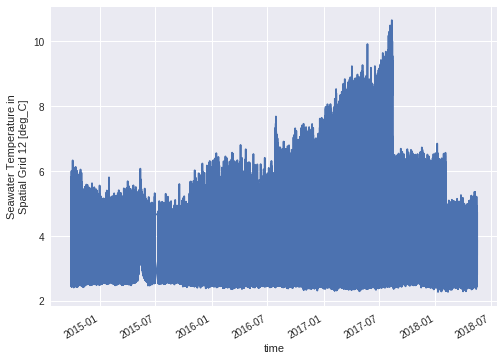

In [11]:
# Given the amount of data, this may take a while to plot
ds['temperature12'].plot()
plt.show();

We can tell that the peak temperature is increasing, but this simple line plot does not reveal the internal data distribution. Let's convert to pandas dataframe and downsample from 1 Hz to 1/60 Hz. This step may take 5-10 minutes. 

In [12]:
%%time
from dask.diagnostics import ProgressBar
with ProgressBar():
    df = ds['temperature12'].to_dataframe()
    df = df.resample('min').mean()

[########################################] | 100% Completed |  1min 22.1s
[######                                  ] | 15% Completed | 36.5s

[########################################] | 100% Completed |  2min 31.2s
[                                        ] | 0% Completed | 17.6s

[########################################] | 100% Completed |  2min 31.6s
[                                        ] | 0% Completed |  7.5s

[########################################] | 100% Completed |  2min 43.0s
CPU times: user 8min 28s, sys: 5min 23s, total: 13min 51s
Wall time: 11min 10s


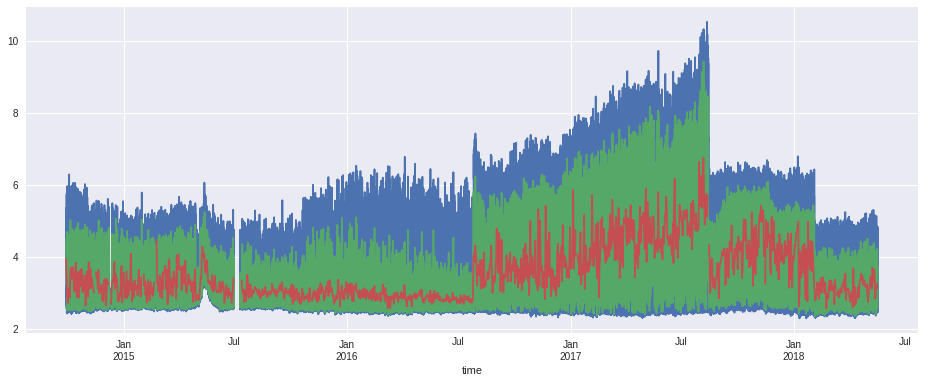

CPU times: user 8.1 s, sys: 185 ms, total: 8.29 s
Wall time: 8.09 s


In [13]:
%%time
plt.close()
fig, ax = plt.subplots()
fig.set_size_inches(16, 6)
df['temperature12'].plot(ax=ax)
df['temperature12'].resample('H').mean().plot(ax=ax)
df['temperature12'].resample('D').mean().plot(ax=ax)
plt.show()

Now we are getting a better sense of the data. Let's convert time to ordinal, grab temperature values and re-examine using hexagonal bi-variate binning. Again, this step may take a few minutes.

In [14]:
%%time
time = []
time_pd = pd.to_datetime(ds.time.values.tolist())
for i in time_pd:
    i = np.datetime64(i).astype(datetime.datetime)
    time.append(dates.date2num(i)) 

CPU times: user 2min 1s, sys: 0 ns, total: 2min 1s
Wall time: 2min 1s


In [0]:
temperature = ds['temperature12'].values.tolist()

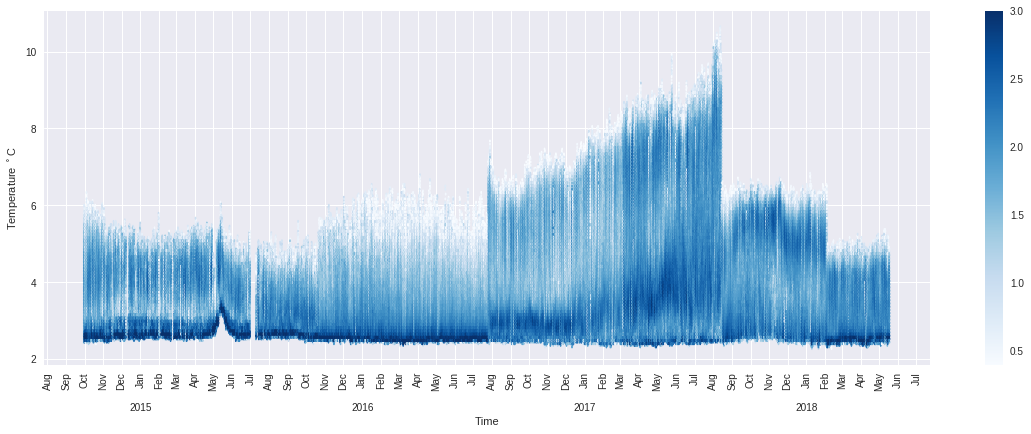

In [16]:
plt.close()
fig, ax = plt.subplots()
fig.set_size_inches(16, 6)

hb1 = ax.hexbin(time, temperature, bins='log', vmin=0.4, vmax=3, gridsize=(1100, 100), mincnt=1, cmap='Blues')
fig.colorbar(hb1)
ax.yaxis.grid(True)
ax.xaxis.grid(True)
# ax.set_xlim(datetime.datetime(2015, 12, 1, 0, 0),datetime.datetime(2016, 7, 25, 0, 0))
# ax.set_ylim(2,11)
years = dates.YearLocator()
months = dates.MonthLocator()
yearsFmt = dates.DateFormatter('\n\n\n%Y')
monthsFmt = dates.DateFormatter('%b')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFmt)
ax.xaxis.set_minor_locator(years)
ax.xaxis.set_minor_formatter(yearsFmt)
plt.tight_layout()
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)
plt.ylabel('Temperature $^\circ$C')
plt.xlabel('Time')
plt.show()